In [43]:
import pandas as pd
import numpy as  np
import pycaret
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [44]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [45]:
data = pd.read_csv('../../data/raw/01_homely_resort_listing.csv')
data.head()

,accommodates,amenities,availability_30,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,cancellation_policy,guests_included,...,number_of_reviews,property_type,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,room_type,Unnamed: 25,price
0,6,"{""Cable TV"",Internet,""Wireless Internet"",""Air ...",0,2.5,Real Bed,1.0,3.0,1,moderate,1,...,1,House,10.0,10.0,10.0,100.0,10.0,Private room,NaN,$300.00
1,2,"{""Air Conditioning"",Heating,""Family/Kid Friend...",29,0.0,Futon,1.0,1.0,1,moderate,1,...,0,Camper/RV,NaN,NaN,NaN,NaN,NaN,Private room,NaN,$99.00
2,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",30,1.5,Real Bed,1.0,1.0,2,flexible,1,...,0,House,NaN,NaN,NaN,NaN,NaN,Private room,NaN,$100.00
3,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",30,1.5,Real Bed,1.0,1.0,2,flexible,1,...,0,House,NaN,NaN,NaN,NaN,NaN,Private room,NaN,$100.00
4,6,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",27,2.0,Real Bed,3.0,3.0,2,strict,1,...,0,House,NaN,NaN,NaN,NaN,NaN,Entire home/apt,NaN,$599.00


In [46]:
data.shape

(5834, 27)

In [47]:
data.isna().sum()

accommodates                         0
amenities                            0
availability_30                      0
bathrooms                           46
bed_type                             0
bedrooms                             6
beds                                23
calculated_host_listings_count       0
cancellation_policy                  0
guests_included                      0
has_availability                     0
host_is_superhost                   15
host_listings_count                 15
instant_bookable                     0
latitude(North)                      0
longitude(East)                      0
maximum_nights                       0
number_of_reviews                    0
property_type                        0
review_scores_checkin             2057
review_scores_communication       2057
review_scores_location            2056
review_scores_rating              2046
review_scores_value               2057
room_type                            0
Unnamed: 25              

Text(0.5, 1.0, 'Distribution of Room')

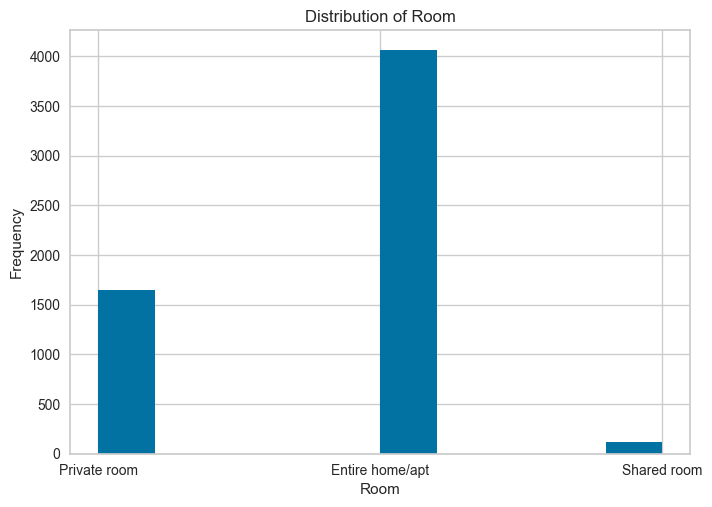

In [48]:
data['room_type'].hist()

# add labels and title
plt.xlabel('Room')
plt.ylabel('Frequency')
plt.title('Distribution of Room')

After looking at the csv file, it is shown that every column in "has_availability" has the same value of "t" hence the column will be removed.

I will also remove outliers in the "host_listing_count" as some values are way above the norm such as 301 and 339

in "host_is_superhost", "instant_bookable" column, since the values are 't' or 'f' the values will be replaced to 1 and 0

"maximum_nights" will be filtered down to have a maximum value of 365 as there are "interesting" values such as 9999 and 26000

next, columns such as "bed_type", "cancellation_policy", "property_type", "room_type" will be converted to categorical values

lastly the "amenities" column will be dropped for convenience sakes

if everything seems correct, the final dataframe will have 1424 rows

In [49]:
data.shape

(5834, 27)

In [50]:
# changing the format of the price from $300.00 to 300.00
data['price'] = data['price'].replace('[^\d.]','',regex=True)

#drop columns
data = data.drop(columns='Unnamed: 25')
data = data.dropna()
data = data.drop(columns=['has_availability','amenities'])

#filtering data
data = data[data['host_listings_count'] < 50]
data = data[data['maximum_nights'] <= 365]

#replacing string to binary
data['host_is_superhost'] = data['host_is_superhost'].replace({'t': 1, 'f': 0})
data['instant_bookable'] = data['instant_bookable'].replace({'t': 1, 'f': 0})

#replacing string with categorical values
data['bed_type'] = data['bed_type'].astype('object')
data['cancellation_policy'] = data['cancellation_policy'].astype('object')
data['property_type'] = data['property_type'].astype('object')
data['room_type'] = data['room_type'].astype('object')

data['price'] = data['price'].astype(float).astype(int)


In [51]:
data.shape
data = data.reset_index()

In [52]:
data.head()

,index,accommodates,availability_30,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,cancellation_policy,guests_included,...,maximum_nights,number_of_reviews,property_type,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,room_type,price
0,0,6,0,2.5,Real Bed,1.0,3.0,1,moderate,1,...,10,1,House,10.0,10.0,10.0,100.0,10.0,Private room,300
1,7,2,16,1.0,Real Bed,1.0,1.0,1,moderate,2,...,7,2,House,10.0,10.0,10.0,100.0,10.0,Private room,40
2,12,2,25,1.0,Real Bed,1.0,1.0,5,strict,1,...,14,4,House,10.0,10.0,10.0,100.0,10.0,Private room,49
3,23,6,19,1.0,Real Bed,1.0,2.0,1,moderate,4,...,30,76,House,10.0,10.0,9.0,94.0,10.0,Private room,50
4,26,2,19,1.5,Real Bed,1.0,2.0,2,strict,2,...,28,14,House,10.0,10.0,9.0,99.0,10.0,Private room,49


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424 entries, 0 to 1423
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           1424 non-null   int64  
 1   accommodates                    1424 non-null   int64  
 2   availability_30                 1424 non-null   int64  
 3   bathrooms                       1424 non-null   float64
 4   bed_type                        1424 non-null   object 
 5   bedrooms                        1424 non-null   float64
 6   beds                            1424 non-null   float64
 7   calculated_host_listings_count  1424 non-null   int64  
 8   cancellation_policy             1424 non-null   object 
 9   guests_included                 1424 non-null   int64  
 10  host_is_superhost               1424 non-null   int64  
 11  host_listings_count             1424 non-null   float64
 12  instant_bookable                14

In [54]:
from pycaret.regression import *
s = setup(data, target='price',train_size=0.8, normalize=True, session_id = 123, fold = 10, experiment_name = 'homes_v2')

,Description,Value
0,Session id,123
1,Target,price
2,Target type,Regression
3,Original data shape,"(1424, 25)"
4,Transformed data shape,"(1424, 47)"
5,Transformed train set shape,"(1139, 47)"
6,Transformed test set shape,"(285, 47)"
7,Numeric features,20
8,Categorical features,4
9,Preprocess,True


In [55]:
best = compare_models(errors='raise')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,87.8671,29037.3898,164.7128,0.6515,0.4801,0.4608,1.1070
lightgbm,Light Gradient Boosting Machine,93.5382,31250.8780,172.1539,0.6188,0.5551,0.5115,0.1460
gbr,Gradient Boosting Regressor,93.9074,32750.2408,175.5730,0.6002,0.5509,0.5149,0.1450
rf,Random Forest Regressor,98.5638,34781.1946,181.1388,0.5802,0.5138,0.5597,0.3090
et,Extra Trees Regressor,101.9568,37636.4542,187.2386,0.5526,0.5254,0.5597,0.2540
xgboost,Extreme Gradient Boosting,101.4926,37789.0339,190.5425,0.5212,0.5495,0.5600,0.1080
br,Bayesian Ridge,114.2036,40953.3114,195.6787,0.5091,0.7431,0.7269,0.0600
en,Elastic Net,109.8092,42013.9663,197.5966,0.5059,0.6534,0.6652,0.0630
lasso,Lasso Regression,115.4099,41232.8210,196.4391,0.5036,0.7467,0.7445,0.0540
llar,Lasso Least Angle Regression,115.4102,41232.7617,196.4390,0.5036,0.7468,0.7445,0.0600


In [57]:
best.get_params()

{'loss_function': 'RMSE',
 'border_count': 254,
 'verbose': False,
 'task_type': 'CPU',
 'random_state': 123}

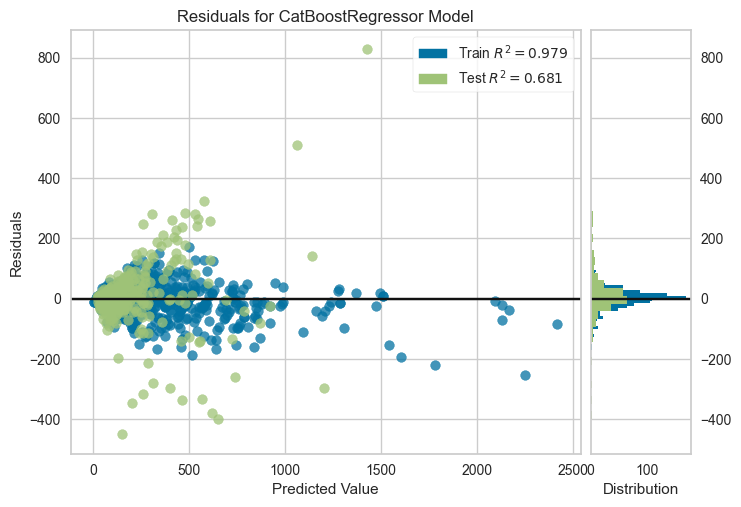

In [58]:
plot_model(best, plot='residuals')

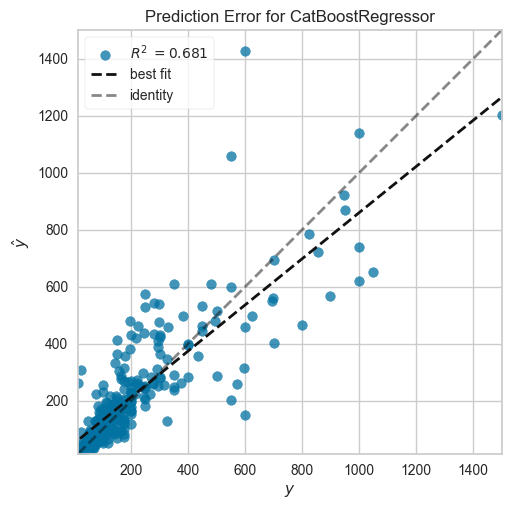

In [59]:
plot_model(best,plot='error')

In [60]:
tuned = tune_model(best, return_tuner=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,89.5171,42133.7455,205.2651,0.6519,0.4982,0.4876
1,98.7137,26308.7801,162.1998,0.6765,0.5219,0.5163
2,88.7952,18683.1455,136.6863,0.7169,0.5691,0.6337
3,100.5058,32430.2610,180.0840,0.4149,0.4871,0.4177
4,90.5907,20290.1423,142.4435,0.4769,0.6358,0.7037
5,109.3451,78070.7811,279.4115,0.5259,0.4916,0.3771
6,84.4570,23572.4601,153.5333,0.7315,0.4593,0.4156
7,74.8872,15102.6097,122.8927,0.8172,0.4037,0.3520
8,76.8132,13117.3870,114.5312,0.7664,0.4354,0.3900


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [61]:
best_tuned = tuned[0]

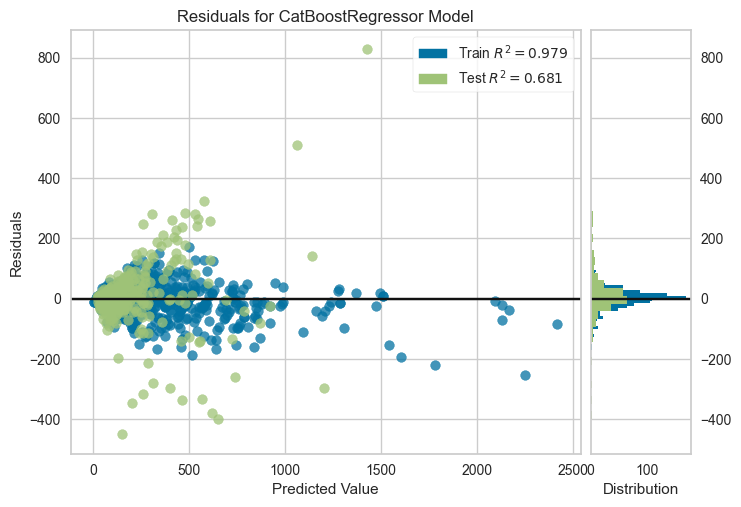

In [62]:
plot_model(best_tuned, plot='residuals')

In [63]:
holdout_pred = predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,68.4777,14299.9978,119.5826,0.6810,0.4615,0.4580


In [64]:
holdout_pred.head()

,index,accommodates,availability_30,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,cancellation_policy,guests_included,...,number_of_reviews,property_type,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,room_type,price,prediction_label
1184,4560,6,23,1.0,Real Bed,2.0,2.0,4,strict,7,...,49,House,10.0,10.0,10.0,95.0,9.0,Entire home/apt,165,284.963462
1422,5821,4,6,1.0,Real Bed,1.0,2.0,2,strict,2,...,195,Apartment,10.0,10.0,10.0,96.0,9.0,Entire home/apt,150,138.388614
980,3823,4,5,2.0,Real Bed,1.0,2.0,1,strict,2,...,2,Apartment,9.0,7.0,8.0,80.0,8.0,Private room,90,119.158198
969,3780,4,16,1.0,Real Bed,1.0,1.0,2,strict,2,...,37,House,10.0,10.0,10.0,97.0,9.0,Private room,129,104.675226
320,1428,3,7,1.0,Real Bed,1.0,1.0,1,moderate,2,...,15,Apartment,10.0,10.0,10.0,100.0,10.0,Entire home/apt,175,131.005484


In [65]:
save_model(best, 'homely_resort')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['index', 'accommodates',
                                              'availability_30', 'bathrooms',
                                              'bedrooms', 'beds',
                                              'calculated_host_listings_count',
                                              'guests_included',
                                              'host_is_superhost',
                                              'host_listings_count',
                                              'instant_bookable',
                                              'latitude(North)',
                                              'longitude(East)',
                                              'maximum_nights',
                                              'number_of_reviews',...
                                     transformer=OneHotEncoder(cols=['bed_type',
              

In [66]:
load_pipeline = load_model('homely_resort')
load_pipeline

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=C:\Users\ZUDEAN~1\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['index', 'accommodates',
                                             'availability_30', 'bathrooms',
                                             'bedrooms', 'beds',
                                             'calculated_host_listings_count',
                                             'guests_included',
                                             'host_is_superhost',
                                             'host_listings_count',
                                             'instant_bookable',
                                             'latitude(North)',
                                             'longitude(E...
                                    transformer=OneHotEncoder(cols=['bed_type',
                                                                    'cancellation_policy',
                                                                    'property_type',
                                                                    'room_type'],
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('clean_column_names',
                 TransformerWrapper(transformer=CleanColumnNames())),
                ('trained_model',
                 <catboost.core.CatBoostRegressor object at 0x000001BA7B7371C0>)])

In [67]:
!mlflow ui

^C


In [70]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

mlflow.set_experiment(experiment_id="239846606708982393")

<Experiment: artifact_location='mlflow-artifacts:/239846606708982393', creation_time=1708696542899, experiment_id='239846606708982393', last_update_time=1708696542899, lifecycle_stage='active', name='homes_v2', tags={}>

In [71]:
y_true = holdout_pred['price']
y_pred = holdout_pred['prediction_label']

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)
mlflow.end_run()


# Start an MLflow run
with mlflow.start_run() as run:
    mlflow.log_param('train_size', 0.8)
    mlflow.log_param('normalize', True)
    mlflow.log_param('fold',10)
    
    # Log metrics
    mlflow.log_metric('MAE', mae)
    mlflow.log_metric('MSE', mse)
    mlflow.log_metric('RMSE', rmse)
    mlflow.log_metric('R2', r2)
    
    # Set the experiment name (note: this should be set before logging parameters)
    mlflow.set_experiment('homes_v2')
    mlflow.log_param('experiment_name', 'homes_v2')
    mlflow.log_param('run_id', run.info.run_id)
    
    
    # Log the Sklearn model
    mlflow.sklearn.log_model(sk_model=best_tuned, registered_model_name='homes_v2', artifact_path='sk_model')

Successfully registered model 'homes_v2'.
2024/02/23 21:57:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: homes_v2, version 1
Created version '1' of model 'homes_v2'.
